**New Update : 
This notebook displays the results of a search for noisy features. This search has been carried in RandomForest mode.**

In [20]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import gc
gc.collect()
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler

In [46]:

#Add All the Models Libraries

# Scalers
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse
from sklearn.feature_selection import RFECV

In [22]:
# to make this notebook's output stable across runs
np.random.seed(123)
gc.collect()
# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [23]:
#Reduce the memory usage - Inspired by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [24]:
train = reduce_mem_usage(pd.read_csv('../input/train.csv',parse_dates=["first_active_month"]))
test = reduce_mem_usage(pd.read_csv('../input/test.csv', parse_dates=["first_active_month"]))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [25]:
train.shape

(201917, 6)

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int8
feature_2             201917 non-null int8
feature_3             201917 non-null int8
target                201917 non-null float16
dtypes: datetime64[ns](1), float16(1), int8(3), object(1)
memory usage: 4.0+ MB


Text(0.5,0,'Customer Loyality (Skewed)')

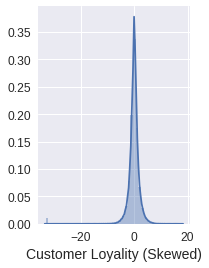

In [27]:
plt.subplot(1, 2, 2)
sns.distplot(train.target, kde=True, fit = norm)
plt.xlabel('Customer Loyality (Skewed)')

In [28]:
# Now extract the month, year, day, weekday
train["month"] = train["first_active_month"].dt.month
train["year"] = train["first_active_month"].dt.year
train['week'] = train["first_active_month"].dt.weekofyear
train['dayofweek'] = train['first_active_month'].dt.dayofweek
train['days'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
train['quarter'] = train['first_active_month'].dt.quarter
train['is_month_start'] = train['first_active_month'].dt.is_month_start

#Interaction Variables
train['days_feature1'] = train['days'] * train['feature_1']
train['days_feature2'] = train['days'] * train['feature_2']
train['days_feature3'] = train['days'] * train['feature_3']

test["month"] = test["first_active_month"].dt.month
test["year"] = test["first_active_month"].dt.year
test['week'] = test["first_active_month"].dt.weekofyear
test['dayofweek'] = test['first_active_month'].dt.dayofweek
test['days'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days
test['quarter'] = test['first_active_month'].dt.quarter
test['is_month_start'] = test['first_active_month'].dt.is_month_start

#Interaction Variables
test['days_feature1'] = test['days'] * train['feature_1']
test['days_feature2'] = test['days'] * train['feature_2']
test['days_feature3'] = test['days'] * train['feature_3']

Now we will try to extract more features from Transactions Data

In [29]:
# Taking Reference from Other Kernels
def aggregate_transaction_hist(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean', 'min', 'max', 'var'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum','mean', 'max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],  
        'month_lag': ['max','min','mean','var'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique']
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [30]:
transactions = reduce_mem_usage(pd.read_csv('../input/historical_transactions.csv'))
transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
transactions['category_1'] = transactions['category_1'].map({'Y': 1, 'N': 0})

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


In [31]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions['year'] = transactions['purchase_date'].dt.year
transactions['weekofyear'] = transactions['purchase_date'].dt.weekofyear
transactions['month'] = transactions['purchase_date'].dt.month
transactions['dayofweek'] = transactions['purchase_date'].dt.dayofweek
transactions['weekend'] = (transactions.purchase_date.dt.weekday >=5).astype(int)
transactions['hour'] = transactions['purchase_date'].dt.hour 
transactions['quarter'] = transactions['purchase_date'].dt.quarter
transactions['is_month_start'] = transactions['purchase_date'].dt.is_month_start
transactions['month_diff'] = ((datetime.datetime.today() - transactions['purchase_date']).dt.days)//30
transactions['month_diff'] += transactions['month_lag']

#impute missing values - This is now excluded.
transactions['category_2'] = transactions['category_2'].fillna(1.0,inplace=True)
transactions['category_3'] = transactions['category_3'].fillna('A',inplace=True)
transactions['merchant_id'] = transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

transactions['category_3'] = transactions['category_3'].map({'A':0, 'B':1, 'C':2})
gc.collect()

256

In [32]:
agg_func = {
        'mean': ['mean'],
    }
for col in ['category_2','category_3']:
    transactions[col+'_mean'] = transactions['purchase_amount'].groupby(transactions[col]).agg('mean')
    transactions[col+'_max'] = transactions['purchase_amount'].groupby(transactions[col]).agg('max')
    transactions[col+'_min'] = transactions['purchase_amount'].groupby(transactions[col]).agg('min')
    transactions[col+'_var'] = transactions['purchase_amount'].groupby(transactions[col]).agg('var')
    agg_func[col+'_mean'] = ['mean']
    
gc.collect()

168

In [33]:
merge_trans = aggregate_transaction_hist(transactions, prefix='hist_')
del transactions
gc.collect()
train = pd.merge(train, merge_trans, on='card_id',how='left')
test = pd.merge(test, merge_trans, on='card_id',how='left')
del merge_trans
gc.collect()

56

In [34]:
train.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,week,dayofweek,days,quarter,is_month_start,days_feature1,days_feature2,days_feature3,hist_transactions_count,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_mean,hist_month_diff_min,hist_month_diff_max,hist_month_diff_var,hist_weekend_sum,hist_weekend_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_1_max,hist_category_1_min,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_card_id_size,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_category_id_nunique
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,6,2017,22,3,245,2,True,1225,490,245,260,2018-02-25 09:31:15,2017-06-27 14:18:08,11.053846,11,12,0.051143,90,0.346154,247,0.950000,0,0.000000,0,0,-165.968735,-0.638341,2.258394,-0.739395,0.212139,4,0.015385,1,0,0.123314,0,-8,-3.911538,5.748901,260,9,23,35,7,2,21,41
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,1,2017,52,6,396,1,True,1584,396,0,350,2018-01-31 22:31:09,2017-01-06 16:29:42,12.080000,11,13,0.102464,132,0.377143,339,0.968571,31,0.088571,1,0,-210.006332,-0.600018,4.630300,-0.742400,0.384967,543,1.551429,10,-1,1.510777,0,-12,-5.031429,14.477519,350,12,24,50,7,2,24,57


In [35]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['hist_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
train['hist_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
train['hist_purchase_date_uptonow'] = (datetime.datetime.today() - train['hist_purchase_date_max']).dt.days
train['hist_purchase_date_uptomin'] = (datetime.datetime.today() - train['hist_purchase_date_min']).dt.days
train['hist_first_buy'] = (train['hist_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9
gc.collect()


222

In [36]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
test['hist_purchase_date_max'] = pd.to_datetime(test['hist_purchase_date_max'])
test['hist_purchase_date_min'] = pd.to_datetime(test['hist_purchase_date_min'])
test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_card_id_size']
test['hist_purchase_date_uptonow'] = (datetime.datetime.today() - test['hist_purchase_date_max']).dt.days
test['hist_purchase_date_uptomin'] = (datetime.datetime.today() - test['hist_purchase_date_min']).dt.days

test['hist_first_buy'] = (test['hist_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9

gc.collect()

75

In [37]:
#Check fpr Missing Values after Concatination

obs = train.isnull().sum().sort_values(ascending = False)
percent = round(train.isnull().sum().sort_values(ascending = False)/len(train)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Observations', 'Percent'])

,Number of Observations,Percent
hist_first_buy,0,0.0
days_feature2,0,0.0
hist_authorized_flag_mean,0,0.0
hist_authorized_flag_sum,0,0.0
hist_weekend_mean,0,0.0
hist_weekend_sum,0,0.0
hist_month_diff_var,0,0.0
hist_month_diff_max,0,0.0
hist_month_diff_min,0,0.0
hist_month_diff_mean,0,0.0


In [38]:
#Detect Outlier
# Remove the Outliers if any 
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [39]:
target = train['target']
del train['target']

train = train.drop(['card_id', 'first_active_month'], axis = 1)
test = test.drop(['card_id', 'first_active_month'], axis = 1)

In [40]:
# Now check the shape of Train and Test Data
#train = train.drop(['is_month_start'],axis=1)
train.head(5)

,feature_1,feature_2,feature_3,month,year,week,dayofweek,days,quarter,is_month_start,days_feature1,days_feature2,days_feature3,hist_transactions_count,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_mean,hist_month_diff_min,hist_month_diff_max,hist_month_diff_var,hist_weekend_sum,hist_weekend_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_1_max,hist_category_1_min,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_card_id_size,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_category_id_nunique,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin,hist_first_buy,outliers
0,5,2,1,6,2017,22,3,245,2,True,1225,490,245,260,1.519551e+09,1.498573e+09,11.053846,11,12,0.051143,90,0.346154,247,0.950000,0,0.000000,0,0,-165.968735,-0.638341,2.258394,-0.739395,0.212139,4,0.015385,1,0,0.123314,0,-8,-3.911538,5.748901,260,9,23,35,7,2,21,41,242,0.930769,334,577,26,0
1,4,1,0,1,2017,52,6,396,1,True,1584,396,0,350,1.517438e+09,1.483720e+09,12.080000,11,13,0.102464,132,0.377143,339,0.968571,31,0.088571,1,0,-210.006332,-0.600018,4.630300,-0.742400,0.384967,543,1.551429,10,-1,1.510777,0,-12,-5.031429,14.477519,350,12,24,50,7,2,24,57,390,1.114286,358,748,5,0
2,2,2,0,8,2016,31,0,549,3,True,1098,1098,0,43,1.519759e+09,1.484123e+09,11.023256,11,12,0.023256,11,0.255814,41,0.953488,0,0.000000,0,0,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,0,0.000000,0,0,0.000000,0,-13,-8.604651,14.768549,43,10,14,22,7,2,7,8,412,9.581395,331,744,163,0
3,4,3,0,9,2017,35,4,153,3,True,612,459,0,77,1.519818e+09,1.506443e+09,10.987013,10,11,0.012987,11,0.142857,77,1.000000,12,0.155844,1,0,-49.491364,-0.642745,1.445596,-0.740897,0.261624,84,1.090909,3,-1,0.588974,0,-5,-2.831169,3.247437,77,6,16,20,7,2,13,25,154,2.000000,331,485,25,0
4,1,3,0,11,2017,44,2,92,4,True,92,276,0,133,1.519850e+09,1.510445e+09,11.000000,10,12,0.030303,42,0.315789,128,0.962406,15,0.112782,1,0,-48.687656,-0.366073,7.193041,-0.746156,1.352094,182,1.368421,12,1,1.896862,0,-3,-1.285714,1.054113,133,4,22,17,7,2,17,26,108,0.812030,330,439,11,0


In [41]:
for features in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([features])['outliers'].mean()
    train[features] = train[features].map(order_label)
    test[features] =  test[features].map(order_label)

In [42]:
train = train.reset_index()

Apply Recursive Feature selection on the Random Forest with Stratified K Folds to select important features 

In [47]:
folds = 5
step = 2

rfc = RandomForestRegressor(n_estimators=100, max_features='sqrt', max_depth=10, n_jobs=4)

lgbmcv = RFECV(
              estimator=rfc,
              step=step,
              cv=StratifiedKFold(
                                 n_splits=folds,
                                 shuffle=False,
                                 random_state=42).split(train,train['outliers'].values),
              n_jobs=1,
              verbose=2)

lgbmcv.fit(train,target)

Fitting estimator with 57 features.
Fitting estimator with 55 features.
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting estimator with 5 features.
Fitting estimator with 3 featur

RFECV(cv=<generator object _BaseKFold.split at 0x7f8925a9ceb8>,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=1, scoring=None, step=2, verbose=2)

In [51]:
#Total Set of Features
print ('\n Initial features: ', train.columns.tolist() )

# number of Important features
print ('\n Number of Shortlisted features:')
print (lgbmcv.n_features_)

all_features = [c for c in train.columns if c not in ['target','outliers']] 

sel_features = [f for f, s in zip(all_features, lgbmcv.support_) if s]
print('\n The selected features are {}:'.format(sel_features))


 Initial features:  ['index', 'feature_1', 'feature_2', 'feature_3', 'month', 'year', 'week', 'dayofweek', 'days', 'quarter', 'is_month_start', 'days_feature1', 'days_feature2', 'days_feature3', 'hist_transactions_count', 'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_month_diff_mean', 'hist_month_diff_min', 'hist_month_diff_max', 'hist_month_diff_var', 'hist_weekend_sum', 'hist_weekend_mean', 'hist_authorized_flag_sum', 'hist_authorized_flag_mean', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_1_max', 'hist_category_1_min', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_max', 'hist_purchase_amount_min', 'hist_purchase_amount_std', 'hist_installments_sum', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_month_lag_max', 'hist_month_lag_min', 'hist_month_lag_mean', 'hist_month_lag_var', 'hist_card_id_size', 'hist_month_nunique', 'hist_hour_nunique', 'hist_weekofyear_nuni

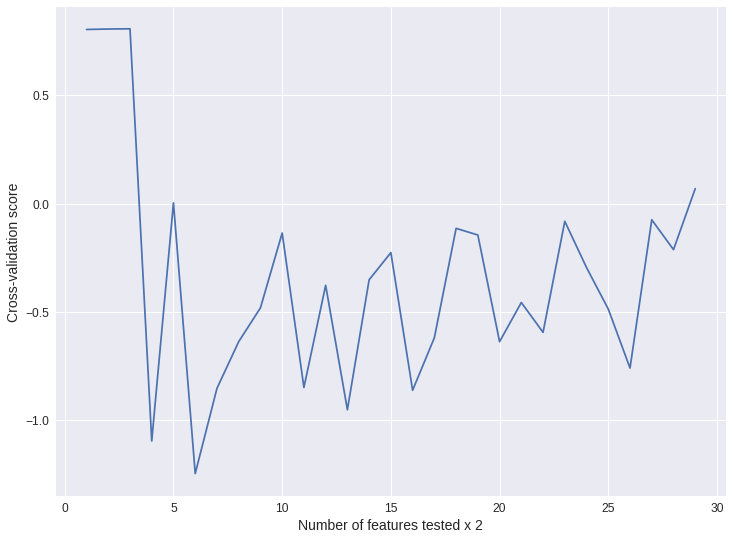

In [53]:
plt.figure(figsize=(12, 9))
plt.xlabel('Number of features tested x 2')
plt.ylabel('Cross-validation score')
plt.plot(range(1, len(lgbmcv.grid_scores_) + 1), lgbmcv.grid_scores_)
plt.savefig('ELO-lgbmcv-01.png', dpi=150)
plt.show()